# Neural Networks

The main focus of this project.

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.utils import resample




### Anchor Relative Dir

In [2]:
import os

# Move working directory to project root if executed inside notebooks/
if os.getcwd().endswith("notebooks"):
    os.chdir("..")

print("Working directory:", os.getcwd())


Working directory: c:\Coding\pytorch\bank-marketing-ml


## Create a Dataset Object

In [3]:
class marketing_dataset(Dataset):
    def __init__(self,X,y):
        self.X = X # these should be tensors by the time we get here
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, index):
        return self.X[index], self.y[index]

### Load Dataset

In [4]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, random_split

dataset_path = "data/processed/bank_processed_unbalanced.csv"
df = pd.read_csv(dataset_path)

X = df.drop(columns=['y_yes']).astype(float).to_numpy()
y = df['y_yes'].to_numpy().astype('int64')

X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y)

full_dataset = marketing_dataset(X_tensor, y_tensor)

total_len = len(full_dataset)
train_len = int(0.8 * total_len)
val_len = int(0.1 * total_len)
test_len = total_len - train_len - val_len

### UNBALANCED SPLIT IF DESIRED

### BALANCE IF DESIRED

In [5]:
train_set, val_set, test_set = random_split(full_dataset, [train_len, val_len, test_len])

minority = df[df["y_yes"] == 1]
majority = df[df["y_yes"] == 0]

majority_down = resample(
    majority,
    replace=False,
    n_samples=len(minority),
    random_state=42
)

df_down = pd.concat([majority_down, minority]).sample(frac=1, random_state=42).reset_index(drop=True)

X_bal = df_down.drop(columns=['y_yes']).astype(float).to_numpy()
y_bal = df_down['y_yes'].to_numpy().astype('int64')

X_bal_tensor = torch.from_numpy(X_bal).float()
y_bal_tensor = torch.from_numpy(y_bal)

full_dataset_bal = marketing_dataset(X_bal_tensor, y_bal_tensor)

total_len_bal = len(full_dataset_bal)
train_len_bal = int(0.8 * total_len_bal)
val_len_bal = int(0.1 * total_len_bal)
test_len_bal = total_len_bal - train_len_bal - val_len_bal

train_set_bal, val_set_bal, test_set_bal = random_split(full_dataset_bal, [train_len_bal, val_len_bal, test_len_bal])

train_loader = DataLoader(train_set_bal, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set_bal, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set_bal, batch_size=64, shuffle=False)


# **Create our Neural Network Object**

In [ ]:
class simpleNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # we don't need to flatten like in the tutorial
        self.linear_relu_stack = nn.Sequential(
            # first linear input should be equal to our number of features
            nn.Linear(39,128), # 39 inputs will be connecting to 128 neurons
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),

        )
    def forward(self, x):
        return self.linear_relu_stack(x)


# **Train the Network**

### Move to gpu

In [7]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


### Create an Instance and move it to the GPU

In [8]:
model = simpleNeuralNetwork().to(device)
print(model)


simpleNeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=39, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)


### Get our Optimizer and criterion
We will be using ADAM, because that's what everyone uses. We use binary cross entropy loss because our model returns 1 logit, representing the log-prob that a person will be a sucess.

In [9]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Training Loop

In [10]:
num_epochs = 45

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).float().unsqueeze(1)  # shape (batch_size, 1)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)

    epoch_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}  Loss: {epoch_loss:.4f}")


Epoch 1/45  Loss: 0.6200
Epoch 2/45  Loss: 0.5715
Epoch 3/45  Loss: 0.5628
Epoch 4/45  Loss: 0.5536
Epoch 5/45  Loss: 0.5480
Epoch 6/45  Loss: 0.5410
Epoch 7/45  Loss: 0.5364
Epoch 8/45  Loss: 0.5301
Epoch 9/45  Loss: 0.5254
Epoch 10/45  Loss: 0.5199
Epoch 11/45  Loss: 0.5151
Epoch 12/45  Loss: 0.5108
Epoch 13/45  Loss: 0.5065
Epoch 14/45  Loss: 0.5007
Epoch 15/45  Loss: 0.4990
Epoch 16/45  Loss: 0.4918
Epoch 17/45  Loss: 0.4877
Epoch 18/45  Loss: 0.4867
Epoch 19/45  Loss: 0.4851
Epoch 20/45  Loss: 0.4794
Epoch 21/45  Loss: 0.4716
Epoch 22/45  Loss: 0.4703
Epoch 23/45  Loss: 0.4638
Epoch 24/45  Loss: 0.4602
Epoch 25/45  Loss: 0.4576
Epoch 26/45  Loss: 0.4496
Epoch 27/45  Loss: 0.4450
Epoch 28/45  Loss: 0.4406
Epoch 29/45  Loss: 0.4397
Epoch 30/45  Loss: 0.4348
Epoch 31/45  Loss: 0.4277
Epoch 32/45  Loss: 0.4240
Epoch 33/45  Loss: 0.4220
Epoch 34/45  Loss: 0.4132
Epoch 35/45  Loss: 0.4119
Epoch 36/45  Loss: 0.4089
Epoch 37/45  Loss: 0.4005
Epoch 38/45  Loss: 0.4053
Epoch 39/45  Loss: 0.

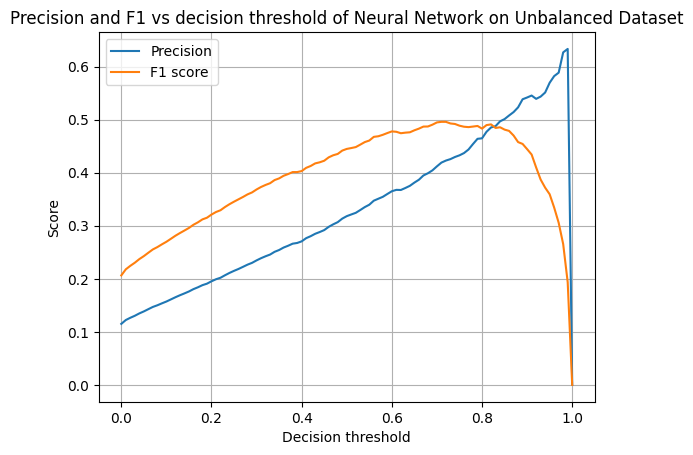

In [11]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import precision_score, f1_score
import matplotlib.pyplot as plt

eval_loader = DataLoader(test_set, batch_size=256, shuffle=False)

model.eval()
all_logits = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in eval_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(X_batch).squeeze(1)
        all_logits.append(logits.cpu())
        all_targets.append(y_batch.cpu())

all_logits = torch.cat(all_logits).numpy()
all_targets = torch.cat(all_targets).numpy()

probs = 1 / (1 + np.exp(-all_logits))

thresholds = np.linspace(0.0, 1.0, 101)
precisions = []
f1s = []

for t in thresholds:
    preds = (probs >= t).astype(int)
    precisions.append(precision_score(all_targets, preds, zero_division=0))
    f1s.append(f1_score(all_targets, preds, zero_division=0))

plt.figure()
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, f1s, label="F1 score")
plt.xlabel("Decision threshold")
plt.ylabel("Score")
plt.title("Precision and F1 vs decision threshold of Neural Network on Unbalanced Dataset")
plt.grid(True)
plt.legend()
plt.show()



In [12]:
from sklearn.metrics import confusion_matrix, classification_report

eval_loader = DataLoader(test_set, batch_size=256, shuffle=False)

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in eval_loader:
        X_batch = X_batch.to(device)
        logits = model(X_batch).squeeze(1)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).long()
        all_preds.append(preds.cpu())
        all_targets.append(y_batch.cpu())

all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

print(confusion_matrix(all_targets, all_preds))
print(classification_report(all_targets, all_preds))




[[3046  791]
 [ 130  369]]
              precision    recall  f1-score   support

           0       0.96      0.79      0.87      3837
           1       0.32      0.74      0.44       499

    accuracy                           0.79      4336
   macro avg       0.64      0.77      0.66      4336
weighted avg       0.89      0.79      0.82      4336



# **ANALYSIS** - UNBALANCED
A neural network, even on the unbalanced dataset, can still produce much higher scores than the baseline models. This is due to the weak signals present throughout. Still, its only at 0.37 f1 score for the positive class. However, the precision on the postive class is worse - neural networks tend to overfit the majority.
# **ANALYSIS** - BALANCED
A 1% less precision on the positive class, but a -3% F1 score, totaling to 0.40. So our current downsampling, while improving baselines, is doing so in a way that negatively impacts how the neural network approximates the function.

In [ ]:
# save the model